<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. Загрузка датасета**

In [ ]:
import seaborn as sns
df = sns.load_dataset('iris')
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df[['species']]

**1. STOLP**

Отступ -- величина, равная  разности между степенью близости объекта к своему классу и суммой близостей объекта ко всем остальным классам. Отступ показывает типичность объекта.

$M(x_i) = W_{y_i}(x_i, X^l) - \max{W_y(x_i, X^l)}$.

Элементы обучающей выборки можно разделить на 5 классов: 

1) Эталонные объекты -- типичные представители своего класса

2) Неинформативные - объекты, которые сильно не влияют на качество классификации

3) Пограничные - объекты, имеющие отступ, близкий к нулю. Незначительное изменение повлияет на их классификацию.

4) Ошибочные - объекты с отрицательными отступами, классифицируемые неверно.

5) Шумовые объекты (выбросы) - малая группа объектов с большими отрицательными отступами.

\\

Нижен реализован алгоритм STOLP на основе классификатора KNN

1) Считаются все отступы объектов

2) Отступы сортируются, находится пара соседних с наибольшей разницей значений, левый элемент пары считаем началом шумов

3) Удаляем шумы из выборки

4) Находим эталоны для каждого класса, объекты с наибольшими отступами и помещаем в $\Omega$

5) Пока $\Omega \neq X^l$ находим среди ошибочно распознаваемых объектов объект с наименьшим отступом и помещаем его в $\Omega$

6) Если число ошибок меньше заданного $l_0$ останавливаем работу алгоритма

In [ ]:
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

"""
Класс, реализующий алгоритм STOLP на основе классификатора KNN
"""
class STOLPBasedOnKNN:
  """
  Конструктор класса
  X -- выборка (pandas.DataFrame)
  y -- ответы для выборки (pandas.Series)
  k -- число соседей в KNN
  """
  def __init__(self, X, y, k):
    self.X = X
    self.y = y
    self.k = k
    self.size = len(X)
    self.tree = KDTree(X)
  
  """
  Метод считает отступ от объекта до заданного множества исходной выборки
  X -- подмножество выборки
  ind -- индекс объекта
  """
  def calc_margin(self, X, ind):
    distances = self.tree.query([self.X.iloc[ind].values], 
                                    k=self.k,
                                    return_distance=False).flatten()
    indexes = self.y[y.species != self.y.values[ind][0]].index
    tree2 = KDTree(self.X.iloc[indexes])                      
    distances2 = tree2.query([self.X.iloc[ind].values], 
                                    k=self.k,
                                    return_distance=False).flatten()
    label_counter, label_counter2 = {}, {}
    for label_ind in distances:
      label = self.y.iloc[label_ind].values[0]
      if label not in label_counter:
        label_counter[label] = 0
      label_counter[label] += 1

    for label_ind in distances2:
      label = self.y.iloc[label_ind].values[0]
      if label not in label_counter2:
        label_counter2[label] = 0
      label_counter2[label] += 1
    W_y_i = label_counter[max(label_counter, key=label_counter.get)]
    W_y = label_counter2[max(label_counter2, key=label_counter2.get)]
    return (ind, W_y_i - W_y)

  """
  Метод считает отступы для каждого объекта.
  Считается разность значений на выборке с классом этого объекта и без него. 
  """
  def calc_margins(self):
    margins = []
    for i in range(self.size):
      margin = self.calc_margin(self.X, i)
      margins.append(margin)
    self.margins = margins

  """
  Метод определяет ошибается ли алгоритм на объекте
  ind -- индекс объекта в выборке
  """
  def is_error(ind):
    distances = self._tree.query([self.X.iloc[xi].values], 
                                    k=self.k + 1,
                                    return_distance=False).flatten()
    label_counter = {}
    for label_ind in distances:
      label = self.y.iloc[label_ind].values[0]
      if label not in label_counter:
        label_counter[label] = 0
      label_counter[label] += 1
    f = max(label_counter, key=label_counter.get)
    y = y.values[xi][0]
    return f == y

  """
  Метод находит верхнюю границу отступов для шумов алгоритом крутого склона
  """
  def get_noises_limit(self):
    neg_margins = sorted(filter(lambda x: x[1] < 0, self.margins))
    noise_ind, max_dif = 0, neg_margins[1][1] - neg_margins[0][1]
    for i in range(2, len(neg_margins)):
      if neg_margins[i][1] - neg_margins[i - 1][1] >= max_dif:
        noise_ind = i - 1
        max_dif = neg_margins[i][1] - neg_margins[i - 1][1]
        
    return neg_margins[noise_ind][1]

  """
  Метод реализует алгоритм STOLP. Алгоритм описан выше.
  """
  def stolp(self, l0):
    self.calc_margins()
    
    noise_limit = self.get_noises_limit()
    filtered = [i[0] for i in filter(lambda x: x[1] > noise_limit, self.margins)]

    X_len = len(self.margins)

    omega = []
    standards = {}
    for i in filtered:
      margin = self.calc_margin(self.X.iloc[filtered], i)
      y_i = self.y.values[i][0]
      if y_i not in standards or margin > standards[y_i][1]:
        standards[y_i] = (i, margin)
    
    for k in standards:
      omega.append(standards[k][0])

    while len(omega) < X_len:
      errors = []
      for i in self.margins:
        if i[0] in omega or i[1] >= 0:
          continue
        errors.append((i[0], self.calc_margin(self.X.iloc[omega], i[0])))

      if len(errors) <= l0:
        break
      
      minv = min(errors, key=lambda x: x[1])
      omega.append(minv[0])
    
    return omega

  """
  Метод рисует график отступов
  """
  def draw_margins(self):
    self.calc_margins()
    x_axis = [tick for tick in range(self.size)]
    plt.plot(x_axis, [i[1] for i in sorted(self.margins, key=lambda x: x[1])])
    plt.show()

Построим график отступов на основе классификаторра KNN с $k = 19$:

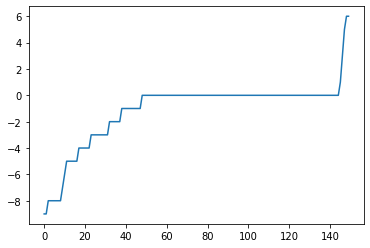

In [ ]:
STOLP = STOLPBasedOnKNN(X, y, 19)
STOLP.draw_margins()

Получаем выборку из эталонов:

In [ ]:
indexes = STOLP.stolp(5)
indexes

[49,
 99,
 149,
 50,
 51,
 52,
 54,
 56,
 58,
 59,
 63,
 66,
 68,
 70,
 72,
 73,
 75,
 76,
 77,
 78,
 83,
 84,
 85,
 86,
 87,
 91,
 101,
 103,
 106,
 110,
 111,
 113,
 114,
 116,
 119,
 121,
 123,
 126,
 127,
 129,
 133,
 134,
 137,
 138,
 139]

Изобразим выбранные эталоны на карте при обучении на двух признаках:


In [ ]:
stolp2 = STOLPBasedOnKNN(X, y, 19)
indexes2 = stolp2.stolp(10)

color = {'virginica': 'blue', 'versicolor': 'red', 'setosa': 'green'}

fig, ax = plt.subplots()

for ind in range(len(X)):
  plt.scatter(X['petal_width'].values[ind], X['petal_length'].values[ind], 
              color='none', edgecolor=color[y.values[ind][0]])
for ind in indexes:
  plt.scatter(X['petal_width'].values[ind], X['petal_length'].values[ind], 
              color=color[y.values[ind][0]])

plt.rcParams['figure.figsize'] = [15, 12]
plt.xticks(np.arange(0, 3.5, 0.5))
plt.yticks(np.arange(1, 7, 0.5))
plt.show()


Подключаем KNN из первого задания:

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree

class KNNClassifier:
    """
    Классификатор, реализующий метод ближайших соседей
    """

    """
    Конструктор класса
    x - pandas.DataFrame с признаками
    y - pandas.Series с метками классов

    Сохраняет в класс признаки с метками, их длину, создает KDTree по признакам.
    """
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._tree = KDTree(x)
        self._size = len(x)
        self._train()

    """
    Метод вычисляющий оптимальное k.
    Реализован LOO. Берутся ближайшие соседи для удаленного элемента из KDTree.
    Создается словарь label_counter с счетчиком меток классов.
    Считаются потери, затем возвращается оптимальное k.
    """

    def _get_optimal_k(self):
        losses = [0] * (self._size - 1)

        for drop_index in range(self._size):
            distances = self._tree.query([self._x.iloc[drop_index].values], 
                                         k=self._size,
                                         return_distance=False).flatten()
            label_counter = {}
            for l_ind, df_ind in enumerate(distances[1:]):
                cur_label = self._y.iloc[df_ind].values[0]
                if cur_label not in label_counter:
                  label_counter[cur_label] = 0
                label_counter[cur_label] += 1
                
                answer = self._y.iloc[drop_index].values[0]
                predicted = max(label_counter, key=label_counter.get)
                losses[l_ind] += answer != predicted

        losses = [i / (self._size - 1) for i in losses]
        self._losses = losses
        return np.argmin(losses) + 1

    """
    Метод train вызывает подсчет оптимального k
    """

    def _train(self):
        self._k = self._get_optimal_k()

    """
    Метод visualize_training визуализирует потери для различных k.
    Использует данные о потерях сохраненные в _losses при подсчет оптимального k.
    """

    def visualize_training(self):
        x_axis = [tick for tick in range(self._size - 1)]
        plt.plot(x_axis, self._losses)
        plt.plot(self._k - 1, self._losses[self._k - 1], 'go')
        plt.show()
        print(f'min at k = {self._k}')

    """
    Метод predict предсказывает метки классов для новых объектов.
    x_pred - pandas.DataFrame с признаками новых объектов.
    Достаются k ближайших объектов из KDTree. Считается самая частая метка
    при помощи метода idxmax (аналог argmin в pandas).
    Возвращается pandas.Series с предсказанными метками.
    """

    def predict(self, x_pred):
        predicted = []
        for obj in x_pred.values:
            distances = self._tree.query([obj], 
                                         k=self._k + 1,
                                         return_distance=False).flatten()
            labels = self._y.iloc[distances[1:]]
            predicted.append(labels.value_counts().idxmax(axis=0)[0])
        return pd.Series(predicted)

Сравним KNN на исходной выборке и выборке из эталонов:

CPU times: user 3.48 s, sys: 9.6 ms, total: 3.49 s
Wall time: 3.51 s


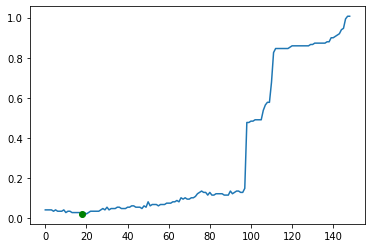

min at k = 19
CPU times: user 329 ms, sys: 2.87 ms, total: 332 ms
Wall time: 331 ms


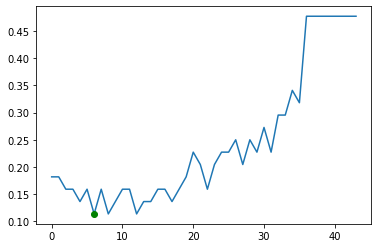

min at k = 7


In [ ]:
%time KNN1 = KNNClassifier(X, y)
KNN1.visualize_training()
%time KNN2 = KNNClassifier(X.iloc[indexes], y.iloc[indexes])
KNN2.visualize_training()


На выборке из эталонов KNN стал показывать результат хуже на $0.09$. Но обучение ускорилось в 10 раз. То есть мы видим, что можно добиться незначительного ухудшения качества работы модели, но при этом многократно ускорить обучение.